# Global Preprocessing Data

## Importation

In [46]:
############ Usual Import ############
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

############ SKLearn ############
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

#Sclaing
from sklearn.preprocessing import RobustScaler

#Machine Learning
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


############ Internal Importation ############
#Importation Données
from analyse.import_data import import_TEMPO

#Preprocessing Interne
from analyse.preproc_RTE import preprocessing_RTE_encours, preproc_temperature_ENEDIS, preproc_tempo
from analyse.preproc_RTE import add_schoolholidays, add_weekday, add_public_holidays

from analyse.feat_eng import set_time_columuns,sin_cos_colonne,shit_colonne


############ Others ############
from lineartree import LinearBoostRegressor
from vacances_scolaires_france import SchoolHolidayDates


############ Vizualisation ############
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})


############ MagicLines ############
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
############ Data Import ############
EnCours_Temps_R = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-TR.csv",delimiter=";")
Temp_Nationale = pd.read_csv("data/donnees-de-temperature-et-de-pseudo-rayonnement.csv",delimiter=";")

#Importation Données Tempo
test = import_TEMPO(deb=2021,fin=2023)
Tempo_RTE_2122 = test['eCO2mix_RTE_tempo_2021-2022']
Tempo_RTE_2223 = test['eCO2mix_RTE_tempo_2022-2023']
Tempo_RTE_2324 = test['eCO2mix_RTE_tempo_2023-2024']

/var/folders/w2/4xgs6mks7dl2p24tsb04p5k80000gn/T/ipykernel_7396/1450642543.py:2: DtypeWarning: Columns (5,26,27,30,31,33,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  EnCours_Temps_R = pd.read_csv("data/puissance/eCO2mix_RTE_En-cours-TR.csv",delimiter=";")


## Why did I choose to process the data "TR"?

J'ai souhaité prendre seumlement le TR pour deux raisons :
- on souhaite prédire pour le lendemain donc plus logique dans la démarceh d'utilisé les valeurs de la veille (ou de S-2 dans le cas de TILT)
- minimiser l'impact COVID, ça ne sert à rien de revenir trop en arrière à cause de l'effet COVID qui va influencer.

- TR : Temps Réel, donc mis à jour avec prévision et modléisation de ce que l'on peut récupérer
- Consolidé : Données consolidé avec échnages des différentes antennes.

## Initial Data

In [27]:
EnCours_Temps_R.head()

,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,...,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz,Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore,Unnamed: 40
0,France,Données temps réel,2022-06-01,00:00,44940.0,44800,45100.0,144.0,0.0,3596.0,...,1054,1677.0,170,584.0,286.0,ND,ND,ND,ND,NaN
1,France,Données temps réel,2022-06-01,00:15,43967.0,43700,43900.0,144.0,0.0,3716.0,...,1419,581.0,171,560.0,276.0,ND,ND,ND,ND,NaN
2,France,Données temps réel,2022-06-01,00:30,42514.0,42600,42700.0,142.0,0.0,2880.0,...,1280,530.0,169,561.0,276.0,ND,ND,ND,ND,NaN
3,France,Données temps réel,2022-06-01,00:45,41073.0,41450,41600.0,143.0,0.0,2699.0,...,1120,361.0,170,563.0,276.0,ND,ND,ND,ND,NaN
4,France,Données temps réel,2022-06-01,01:00,40359.0,40300,40500.0,144.0,3.0,2718.0,...,1101,373.0,170,563.0,276.0,ND,ND,ND,ND,NaN


In [28]:
Temp_Nationale.head()

,horodate,temperature_realisee_lissee_degc,temperature_normale_lissee_degc,temperature_realisee_lissee_temperature_normale_lissee_degc,pseudo_rayonnement,annee,mois,jour,annee_mois_jour
0,2024-01-17T20:00:00+00:00,4.8,4.9,-0.1,28.0,2024,1,17,2024-01-17
1,2024-01-17T14:30:00+00:00,5.8,6.0,-0.2,8.0,2024,1,17,2024-01-17
2,2024-01-17T12:30:00+00:00,5.4,5.8,-0.4,4.0,2024,1,17,2024-01-17
3,2024-01-17T12:00:00+00:00,5.4,5.7,-0.3,3.0,2024,1,17,2024-01-17
4,2024-01-17T08:30:00+00:00,3.7,4.5,-0.8,11.0,2024,1,17,2024-01-17


In [29]:
Tempo_RTE_2324.head()

,Date,Type de jour TEMPO
0,2023-09-01,BLEU
1,2023-09-02,BLEU
2,2023-09-03,BLEU
3,2023-09-04,BLEU
4,2023-09-05,BLEU


Les offres de fourniture d'électricité de type Tempo comportent différents niveaux de prix, variables en fonction de l'heure et des jours de l'année.

- Les jours rouges correspondent aux périodes de l'année où la consommation est forte,
- Les jours blancs à un niveau intermédiaire,
- Les jours bleus sont ceux de plus faible consommation.


## Création Data

### Preprocessing RTE Consommation

In [55]:
df = preprocessing_RTE_encours(EnCours_Temps_R);
df.head(5)

/Users/arthurdubs/code/GitHub_Projects/1_Prediction_Consommation_Electrique_Française/analyse/preproc_RTE.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['date_hour'] = pd.to_datetime(df_final['Date']+ " " + df_final['Heures'])
/Users/arthurdubs/code/GitHub_Projects/1_Prediction_Consommation_Electrique_Française/analyse/preproc_RTE.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Date'] = pd.to_datetime(df_final['Date'])
/Users/arthurdubs/code/GitHub_Projects/1_Prediction_Conso

,Date,Heures,date_hour,Consommation
0,2022-06-01,00:00:00,2022-06-01 00:00:00,44940.0
1,2022-06-01,00:15:00,2022-06-01 00:15:00,43967.0
2,2022-06-01,00:30:00,2022-06-01 00:30:00,42514.0
3,2022-06-01,00:45:00,2022-06-01 00:45:00,41073.0
4,2022-06-01,01:00:00,2022-06-01 01:00:00,40359.0


### Température Nationale

In [31]:
df_temp = preproc_temperature_ENEDIS(Temp_Nationale)
df_temp

/Users/arthurdubs/code/GitHub_Projects/1_Prediction_Consommation_Electrique_Française/analyse/preproc_RTE.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['horodate'] = df_reduced['horodate'].map(lambda x : x[:-6])
/Users/arthurdubs/code/GitHub_Projects/1_Prediction_Consommation_Electrique_Française/analyse/preproc_RTE.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['horodate'] = pd.to_datetime(df_reduced['horodate'],utc=False)
/Users/arthurdubs/code/GitHub_Projects/1_Predic

,date_hour,temperature_realisee_lissee_degc,annee,mois,jour
76660,2019-01-17 23:00:00,5.3,2019,1,17
87647,2019-01-17 23:30:00,5.3,2019,1,17
43837,2019-01-18 00:00:00,5.3,2019,1,18
43836,2019-01-18 00:30:00,5.2,2019,1,18
76659,2019-01-18 01:00:00,5.2,2019,1,18
...,...,...,...,...,...
35472,2024-01-17 20:30:00,4.8,2024,1,17
35471,2024-01-17 21:00:00,4.8,2024,1,17
12131,2024-01-17 21:30:00,4.8,2024,1,17
35470,2024-01-17 22:00:00,4.8,2024,1,17


### Add Column (Weekday, Holidays) to global_df

In [32]:
df = add_weekday(df)
df = add_schoolholidays(df)
df = add_public_holidays(df)
df

,Date,Heures,date_hour,Consommation,weekday,school_holiday,public_holiday
0,2022-06-01,00:00:00,2022-06-01 00:00:00,44940.0,2,0,0
1,2022-06-01,00:15:00,2022-06-01 00:15:00,43967.0,2,0,0
2,2022-06-01,00:30:00,2022-06-01 00:30:00,42514.0,2,0,0
3,2022-06-01,00:45:00,2022-06-01 00:45:00,41073.0,2,0,0
4,2022-06-01,01:00:00,2022-06-01 01:00:00,40359.0,2,0,0
...,...,...,...,...,...,...,...
57274,2024-01-18,14:30:00,2024-01-18 14:30:00,67663.0,3,0,0
57275,2024-01-18,14:45:00,2024-01-18 14:45:00,68208.0,3,0,0
57276,2024-01-18,15:00:00,2024-01-18 15:00:00,67868.0,3,0,0
57277,2024-01-18,15:15:00,2024-01-18 15:15:00,67745.0,3,0,0


### Processing TEMPO Dataframes

In [33]:
Tempo_RTE_2122_preproc = preproc_tempo(Tempo_RTE_2122)
Tempo_RTE_2223_preproc = preproc_tempo(Tempo_RTE_2223)
Tempo_RTE_2324_preproc = preproc_tempo(Tempo_RTE_2324)

In [34]:
tempo_global = pd.concat([Tempo_RTE_2122_preproc, Tempo_RTE_2223_preproc, Tempo_RTE_2324_preproc], axis=0)
tempo_global

,Date,Type de jour TEMPO
0,2021-09-01,BLEU
1,2021-09-02,BLEU
2,2021-09-03,BLEU
3,2021-09-04,BLEU
4,2021-09-05,BLEU
...,...,...
136,2024-01-15,ROUGE
137,2024-01-16,ROUGE
138,2024-01-17,BLANC
139,2024-01-18,ROUGE


### Merge Global

In [35]:
df_merged_temperature = df.merge(df_temp,how='inner',on="date_hour")
df_merged_temperature

,Date,Heures,date_hour,Consommation,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour
0,2022-06-01,00:00:00,2022-06-01 00:00:00,44940.0,2,0,0,15.9,2022,6,1
1,2022-06-01,00:30:00,2022-06-01 00:30:00,42514.0,2,0,0,15.9,2022,6,1
2,2022-06-01,01:00:00,2022-06-01 01:00:00,40359.0,2,0,0,15.8,2022,6,1
3,2022-06-01,01:30:00,2022-06-01 01:30:00,40049.0,2,0,0,15.8,2022,6,1
4,2022-06-01,02:00:00,2022-06-01 02:00:00,39328.0,2,0,0,15.7,2022,6,1
...,...,...,...,...,...,...,...,...,...,...,...
28601,2024-01-17,20:30:00,2024-01-17 20:30:00,67515.0,2,0,0,4.8,2024,1,17
28602,2024-01-17,21:00:00,2024-01-17 21:00:00,65217.0,2,0,0,4.8,2024,1,17
28603,2024-01-17,21:30:00,2024-01-17 21:30:00,63881.0,2,0,0,4.8,2024,1,17
28604,2024-01-17,22:00:00,2024-01-17 22:00:00,62791.0,2,0,0,4.8,2024,1,17


In [36]:
df_merged_temperature_tempo = df_merged_temperature.merge(tempo_global,how='left',on='Date')
df_merged_temperature_tempo

,Date,Heures,date_hour,Consommation,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour,Type de jour TEMPO
0,2022-06-01,00:00:00,2022-06-01 00:00:00,44940.0,2,0,0,15.9,2022,6,1,BLANC
1,2022-06-01,00:30:00,2022-06-01 00:30:00,42514.0,2,0,0,15.9,2022,6,1,BLANC
2,2022-06-01,01:00:00,2022-06-01 01:00:00,40359.0,2,0,0,15.8,2022,6,1,BLANC
3,2022-06-01,01:30:00,2022-06-01 01:30:00,40049.0,2,0,0,15.8,2022,6,1,BLANC
4,2022-06-01,02:00:00,2022-06-01 02:00:00,39328.0,2,0,0,15.7,2022,6,1,BLANC
...,...,...,...,...,...,...,...,...,...,...,...,...
28601,2024-01-17,20:30:00,2024-01-17 20:30:00,67515.0,2,0,0,4.8,2024,1,17,BLANC
28602,2024-01-17,21:00:00,2024-01-17 21:00:00,65217.0,2,0,0,4.8,2024,1,17,BLANC
28603,2024-01-17,21:30:00,2024-01-17 21:30:00,63881.0,2,0,0,4.8,2024,1,17,BLANC
28604,2024-01-17,22:00:00,2024-01-17 22:00:00,62791.0,2,0,0,4.8,2024,1,17,BLANC


## Mise en place Variable Circulaire + Anciennes données

### Circular Variable

In [37]:
df_final = set_time_columuns(df_merged_temperature_tempo)
df_final

,Consommation,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour,Type de jour TEMPO,hour,minute
0,44940.0,2,0,0,15.9,2022,6,1,BLANC,0,0
1,42514.0,2,0,0,15.9,2022,6,1,BLANC,0,30
2,40359.0,2,0,0,15.8,2022,6,1,BLANC,1,0
3,40049.0,2,0,0,15.8,2022,6,1,BLANC,1,30
4,39328.0,2,0,0,15.7,2022,6,1,BLANC,2,0
...,...,...,...,...,...,...,...,...,...,...,...
28601,67515.0,2,0,0,4.8,2024,1,17,BLANC,20,30
28602,65217.0,2,0,0,4.8,2024,1,17,BLANC,21,0
28603,63881.0,2,0,0,4.8,2024,1,17,BLANC,21,30
28604,62791.0,2,0,0,4.8,2024,1,17,BLANC,22,0


In [40]:
col = ['mois','jour','hour','minute','weekday']
df_final = sin_cos_colonne(df_final,col)

,Consommation,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,Type de jour TEMPO,sin_mois,cos_mois,sin_jour,cos_jour,sin_hour,cos_hour,sin_minute,cos_minute,sin_weekday,cos_weekday
0,44940.0,0,0,15.9,2022,BLANC,1.224647e-16,-1.000000,0.201299,0.979530,0.000000,1.000000,0.000000e+00,1.0,0.866025,-0.5
1,42514.0,0,0,15.9,2022,BLANC,1.224647e-16,-1.000000,0.201299,0.979530,0.000000,1.000000,-1.133108e-15,1.0,0.866025,-0.5
2,40359.0,0,0,15.8,2022,BLANC,1.224647e-16,-1.000000,0.201299,0.979530,0.269797,0.962917,0.000000e+00,1.0,0.866025,-0.5
3,40049.0,0,0,15.8,2022,BLANC,1.224647e-16,-1.000000,0.201299,0.979530,0.269797,0.962917,-1.133108e-15,1.0,0.866025,-0.5
4,39328.0,0,0,15.7,2022,BLANC,1.224647e-16,-1.000000,0.201299,0.979530,0.519584,0.854419,0.000000e+00,1.0,0.866025,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28601,67515.0,0,0,4.8,2024,BLANC,5.000000e-01,0.866025,-0.299363,-0.954139,-0.730836,0.682553,-1.133108e-15,1.0,0.866025,-0.5
28602,65217.0,0,0,4.8,2024,BLANC,5.000000e-01,0.866025,-0.299363,-0.954139,-0.519584,0.854419,0.000000e+00,1.0,0.866025,-0.5
28603,63881.0,0,0,4.8,2024,BLANC,5.000000e-01,0.866025,-0.299363,-0.954139,-0.519584,0.854419,-1.133108e-15,1.0,0.866025,-0.5
28604,62791.0,0,0,4.8,2024,BLANC,5.000000e-01,0.866025,-0.299363,-0.954139,-0.269797,0.962917,0.000000e+00,1.0,0.866025,-0.5


### Lagged Variable

In [50]:
shift_col = ["Consommation","temperature_realisee_lissee_degc"]
shift_lagged = [49,25]

df_final = shit_colonne(df_final,shift_col,shift_lagged)
df_final

,Consommation,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour,Type de jour TEMPO,hour,...,temperature_realisee_lissee_degc_shift16,temperature_realisee_lissee_degc_shift17,temperature_realisee_lissee_degc_shift18,temperature_realisee_lissee_degc_shift19,temperature_realisee_lissee_degc_shift20,temperature_realisee_lissee_degc_shift21,temperature_realisee_lissee_degc_shift22,temperature_realisee_lissee_degc_shift23,temperature_realisee_lissee_degc_shift24,temperature_realisee_lissee_degc_shift25
49,42420.0,3,0,0,16.9,2022,6,2,BLEU,0,...,19.6,19.7,19.8,19.9,19.7,19.5,19.3,19.1,18.9,18.7
50,40356.0,3,0,0,16.8,2022,6,2,BLEU,1,...,19.4,19.6,19.7,19.8,19.9,19.7,19.5,19.3,19.1,18.9
51,40299.0,3,0,0,16.8,2022,6,2,BLEU,1,...,19.2,19.4,19.6,19.7,19.8,19.9,19.7,19.5,19.3,19.1
52,39840.0,3,0,0,16.8,2022,6,2,BLEU,2,...,19.0,19.2,19.4,19.6,19.7,19.8,19.9,19.7,19.5,19.3
53,38895.0,3,0,0,16.8,2022,6,2,BLEU,2,...,18.6,19.0,19.2,19.4,19.6,19.7,19.8,19.9,19.7,19.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28601,67515.0,2,0,0,4.8,2024,1,17,BLANC,20,...,5.4,5.4,5.2,5.0,4.8,4.5,4.3,4.0,3.7,3.5
28602,65217.0,2,0,0,4.8,2024,1,17,BLANC,21,...,5.5,5.4,5.4,5.2,5.0,4.8,4.5,4.3,4.0,3.7
28603,63881.0,2,0,0,4.8,2024,1,17,BLANC,21,...,5.6,5.5,5.4,5.4,5.2,5.0,4.8,4.5,4.3,4.0
28604,62791.0,2,0,0,4.8,2024,1,17,BLANC,22,...,5.7,5.6,5.5,5.4,5.4,5.2,5.0,4.8,4.5,4.3


### OneHotEncoder TEMPO

In [51]:
from sklearn.preprocessing import OneHotEncoder
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse =False)

# Fit encoder
ohe.fit(df_final[['Type de jour TEMPO']])

# Display the detected categories
print(f"The categories detected by the OneHotEncoder are {ohe.categories_}")

# Transform the current "Street" column
df_final[ohe.get_feature_names_out()] = ohe.transform(df_final[['Type de jour TEMPO']])

# Drop the column "Street" which has been encoded
df_final.drop(columns = ["Type de jour TEMPO"], inplace = True)

# Show the dataset
df_final.head(3)

The categories detected by the OneHotEncoder are [array(['BLANC', 'BLEU', 'ROUGE'], dtype=object)]


/Users/arthurdubs/.pyenv/versions/3.10.6/envs/interviews/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Consommation,weekday,school_holiday,public_holiday,temperature_realisee_lissee_degc,annee,mois,jour,hour,minute,...,temperature_realisee_lissee_degc_shift19,temperature_realisee_lissee_degc_shift20,temperature_realisee_lissee_degc_shift21,temperature_realisee_lissee_degc_shift22,temperature_realisee_lissee_degc_shift23,temperature_realisee_lissee_degc_shift24,temperature_realisee_lissee_degc_shift25,Type de jour TEMPO_BLANC,Type de jour TEMPO_BLEU,Type de jour TEMPO_ROUGE
49,42420.0,3,0,0,16.9,2022,6,2,0,30,...,19.9,19.7,19.5,19.3,19.1,18.9,18.7,0.0,1.0,0.0
50,40356.0,3,0,0,16.8,2022,6,2,1,0,...,19.8,19.9,19.7,19.5,19.3,19.1,18.9,0.0,1.0,0.0
51,40299.0,3,0,0,16.8,2022,6,2,1,30,...,19.7,19.8,19.9,19.7,19.5,19.3,19.1,0.0,1.0,0.0


# Présentation Dataframe finale

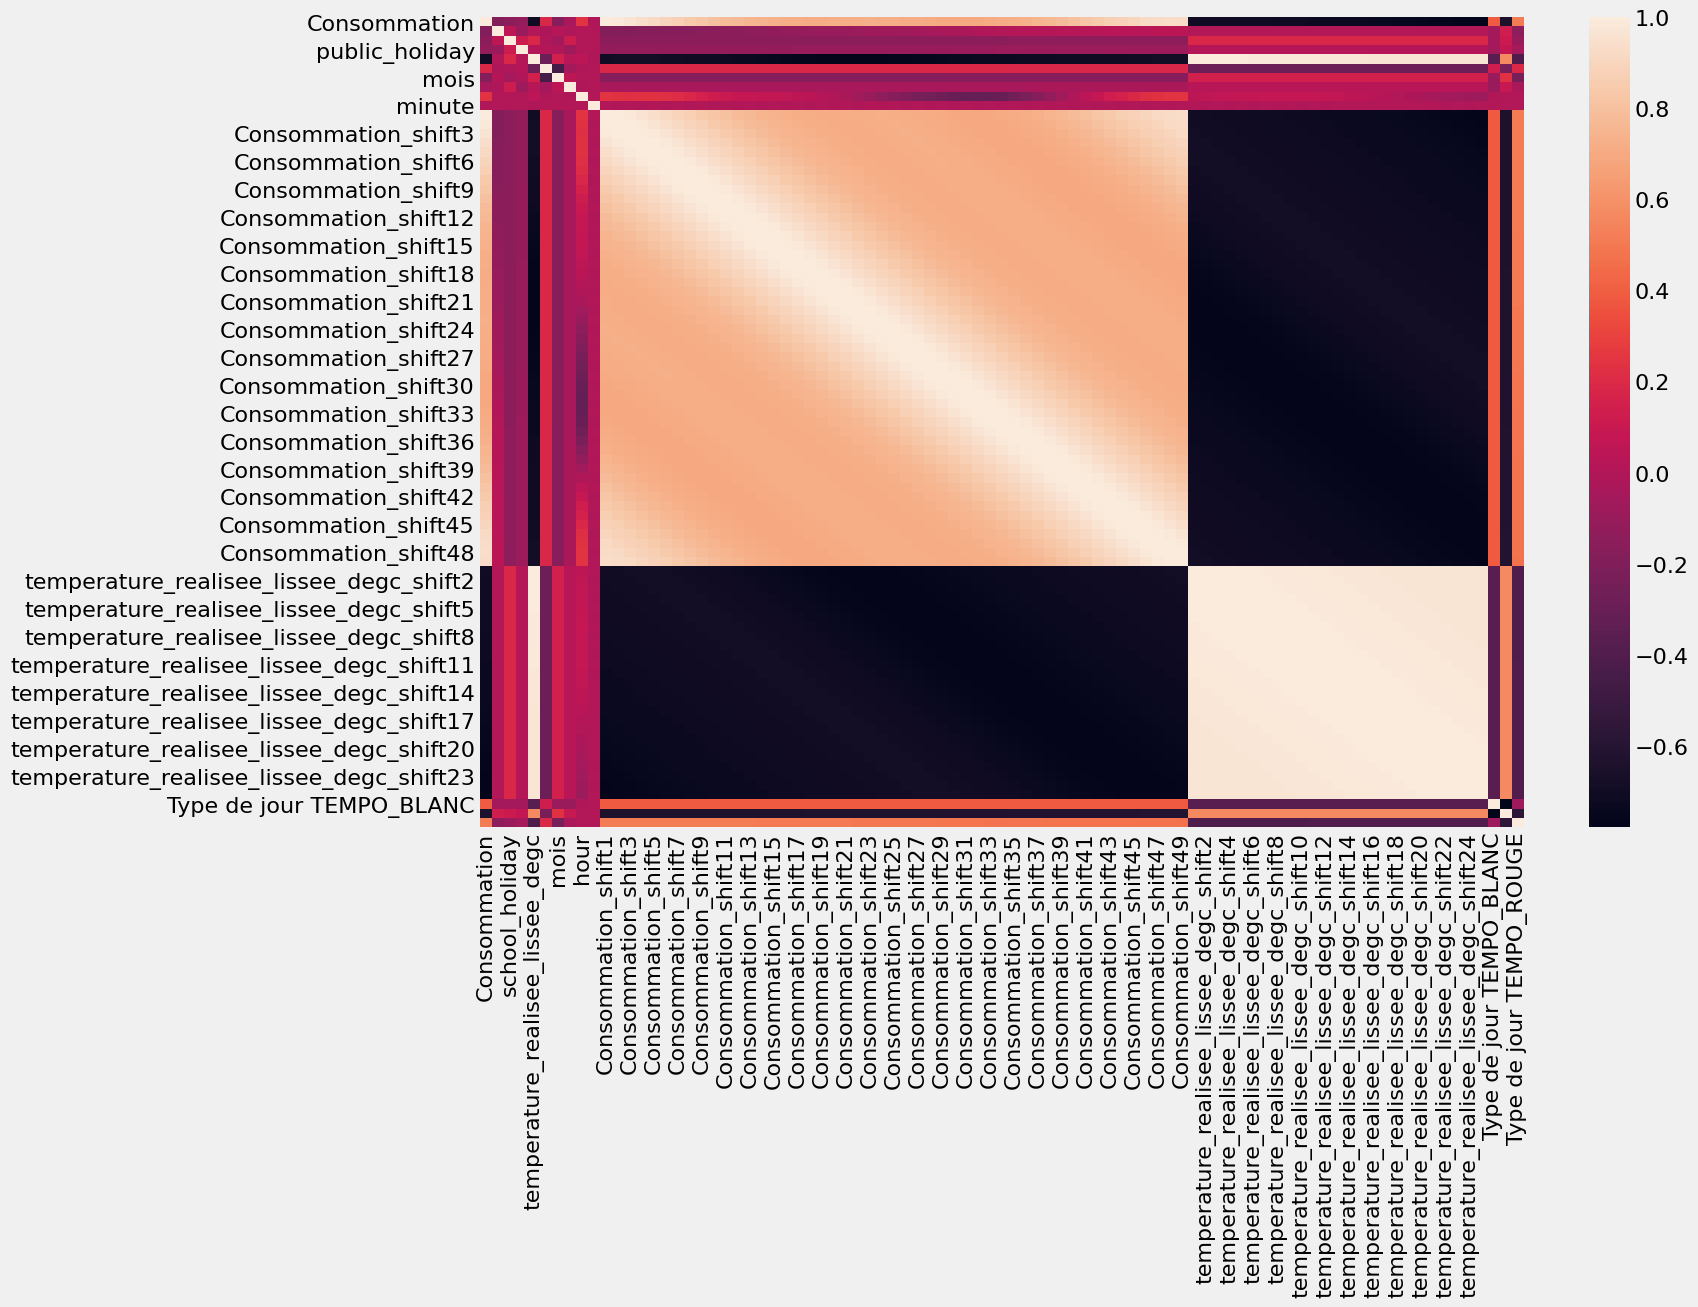

In [54]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_final.corr(method="pearson"), annot=False)
plt.show()

# Enregistrement Datat Finale

#rec 